In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, accuracy_score
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
import nltk

nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)

# Load data
df = pd.read_csv('../dataset/Resume.csv')

# Advanced text preprocessing
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    tokens = text.split()
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return ' '.join(tokens)

df['resume_processed'] = df['Resume_str'].apply(preprocess_text)

# Feature extraction
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X = vectorizer.fit_transform(df['resume_processed'])

# Define target variable and encode labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['Category'])

# Address class imbalance
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

# Train the XGBoost model
xgb = XGBClassifier(random_state=42)
xgb.fit(X_train, y_train)

# Evaluate the model
y_pred = xgb.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"XGBoost Accuracy: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))


XGBoost Accuracy: 0.8316

Classification Report:
                        precision    recall  f1-score   support

            ACCOUNTANT       0.84      0.89      0.86        18
              ADVOCATE       0.81      0.81      0.81        32
           AGRICULTURE       0.89      0.76      0.82        21
               APPAREL       0.69      0.64      0.67        14
                  ARTS       0.85      0.68      0.76        25
            AUTOMOBILE       0.78      0.91      0.84        23
              AVIATION       0.81      0.84      0.82        25
               BANKING       0.68      0.65      0.67        20
                   BPO       0.91      0.95      0.93        22
  BUSINESS-DEVELOPMENT       0.94      0.89      0.91        18
                  CHEF       1.00      0.94      0.97        35
          CONSTRUCTION       0.85      0.96      0.90        23
            CONSULTANT       0.70      0.78      0.74        18
              DESIGNER       0.89      0.96      0.93 

In [ ]:
import joblib

joblib.dump(xgb, '../pkl/xgb_model.pkl')
joblib.dump(vectorizer, '../pkl/vectorizer.pkl')
joblib.dump(label_encoder, '../pkl/label_encoder.pkl')

In [ ]:
from xgboost import DMatrix, train

# Fine-tuning with Grid Search
param_grid = {
    'n_estimators': [200, 300],
    'learning_rate': [0.1, 0.2],
    'max_depth': [3, 4],
    'subsample': [0.8, 1.0]
}

grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=3, n_jobs=-1, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Evaluate the fine-tuned model
best_xgb = grid_search.best_estimator_
dtrain = DMatrix(X_train, label=y_train)
dtest = DMatrix(X_test, label=y_test)

params = best_xgb.get_params()
params['num_class'] = len(np.unique(y_train))  # Add num_class parameter

# Train the model with early stopping
best_xgb_model = train(params, dtrain, num_boost_round=params['n_estimators'], early_stopping_rounds=10, evals=[(dtest, 'eval')], verbose_eval=False)

# Predictions with the fine-tuned model
y_pred = best_xgb_model.predict(dtest)
y_pred = np.argmax(y_pred, axis=1)
accuracy = accuracy_score(y_test, y_pred)
print(f"\nBest Model (XGBoost) Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

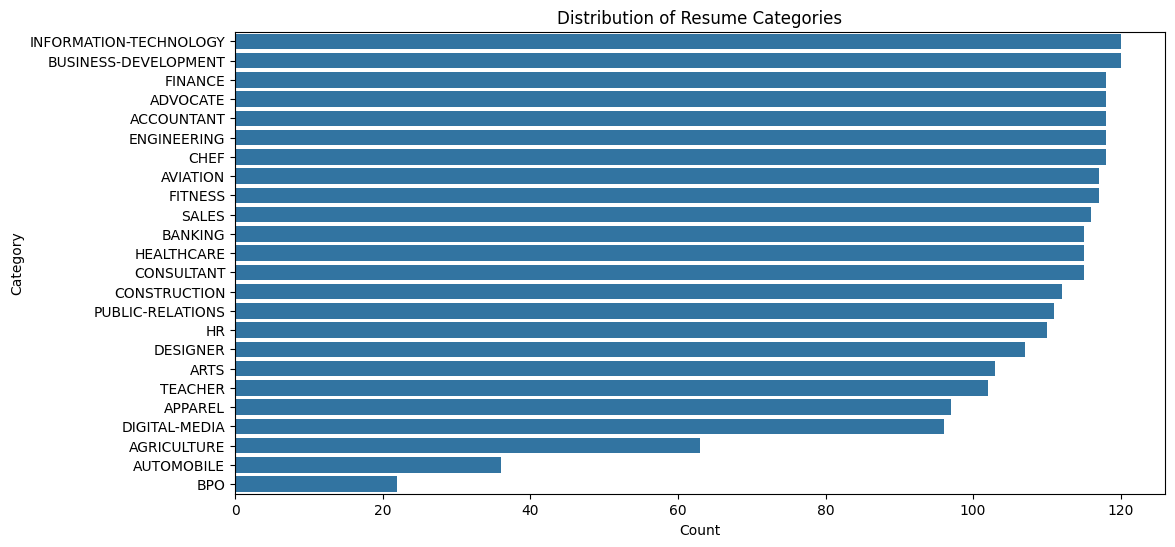

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the distribution of resume categories
plt.figure(figsize=(12, 6))
sns.countplot(y=df['Category'], order=df['Category'].value_counts().index)
plt.title('Distribution of Resume Categories')
plt.xlabel('Count')
plt.ylabel('Category')
plt.show()


##The bar plot displays the number of resumes per category, with "INFORMATION-TECHNOLOGY" and "BUSINESS-DEVELOPMENT" having the most entries, while "BPO" and "AUTOMOBILE" have the fewest. This suggests a potential class imbalance in the dataset that could impact the model's performance.
A potential class imbalance in the dataset could impact the model's performance by causing it to be biased towards the majority classes. As a result, the overall accuracy might be high, but the performance for minority classes would be poor, leading to skewed and unreliable predictions.

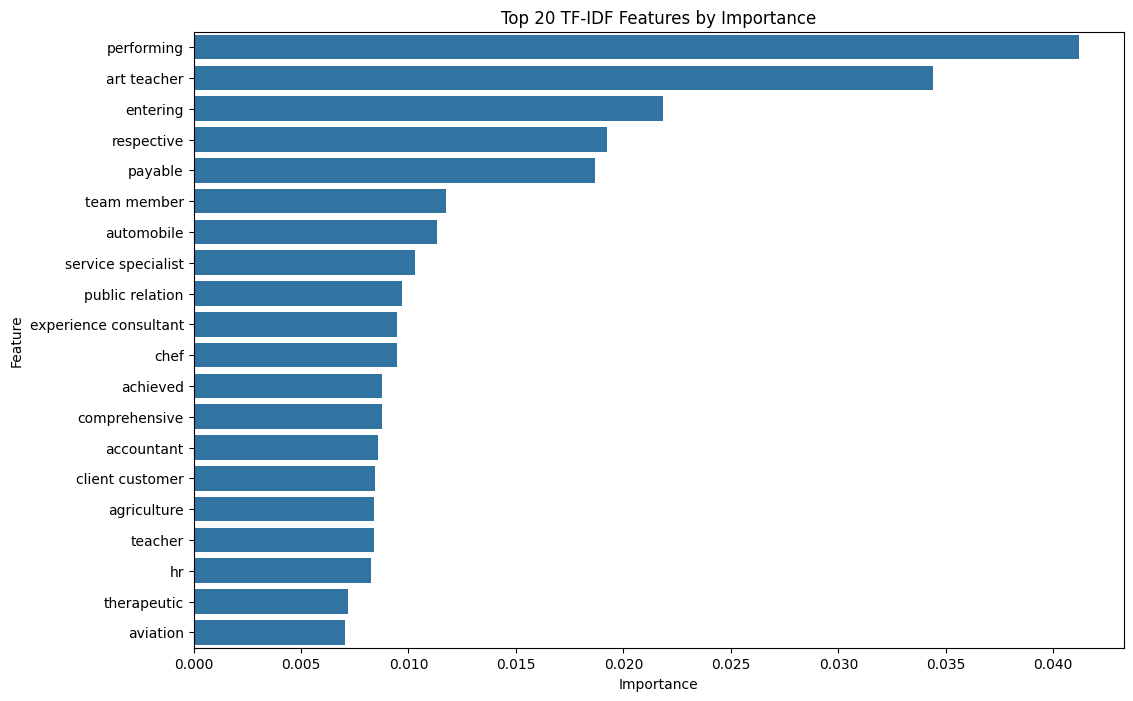

In [6]:
# Get feature importances from the XGBoost model
importance_df = pd.DataFrame({
    'Feature': vectorizer.get_feature_names_out(),
    'Importance': xgb.feature_importances_
}).sort_values(by='Importance', ascending=False).head(20)

# Plot the top 20 important features
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Top 20 TF-IDF Features by Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


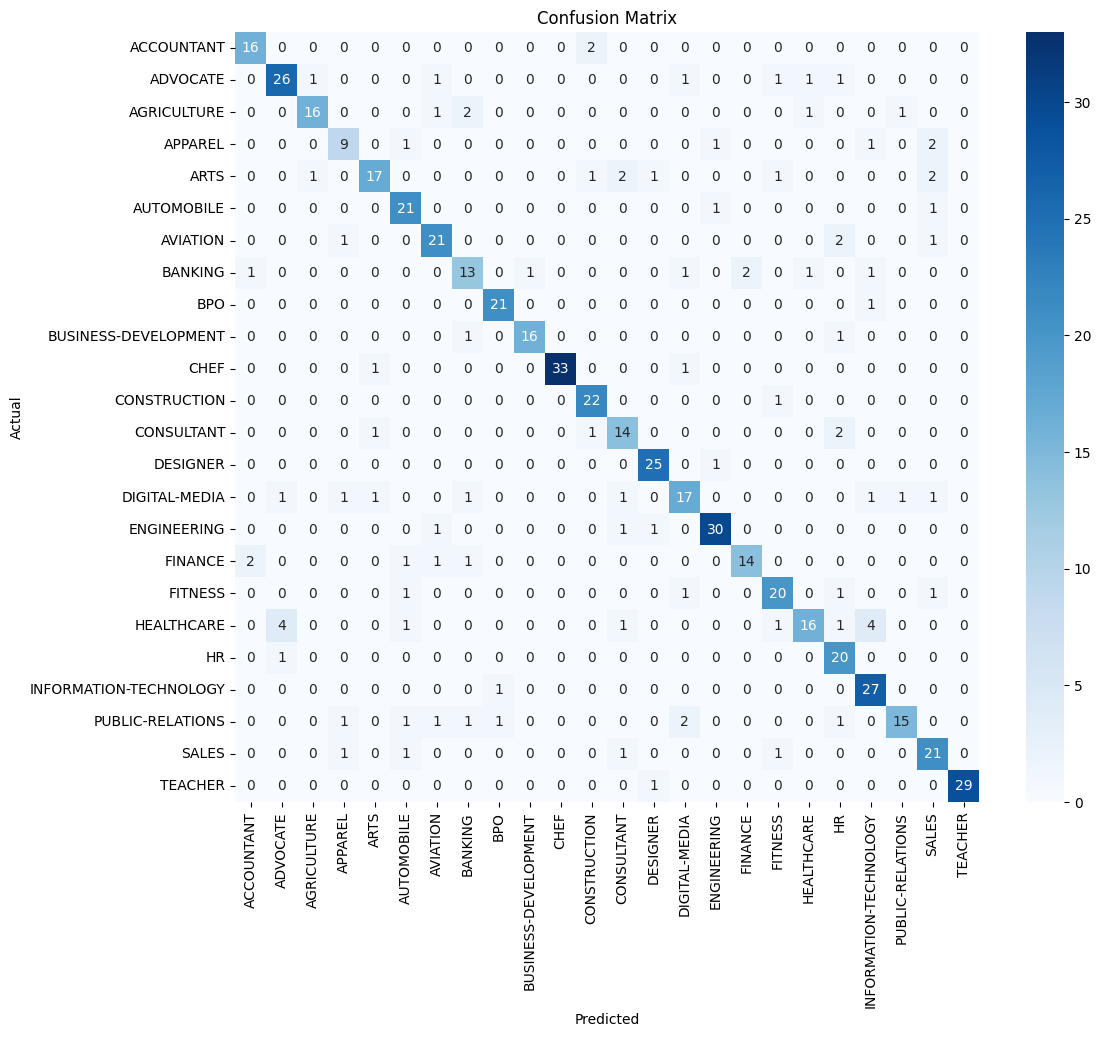

In [7]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Create a confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


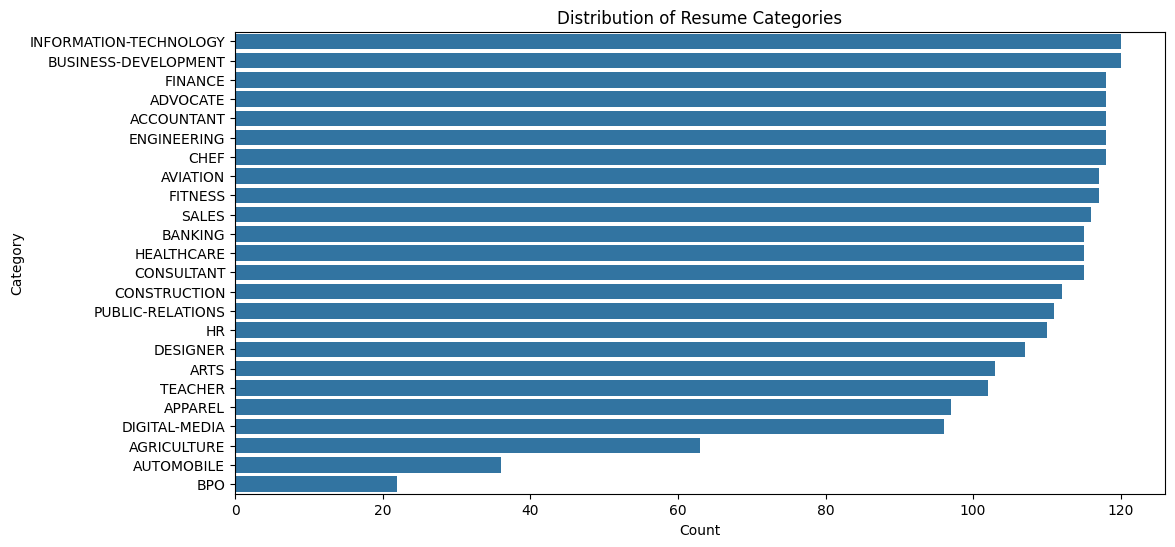

In [11]:
#create Bar Plot of Class Distribution:

import matplotlib.pyplot as plt

# Plot the distribution of resume categories
plt.figure(figsize=(12, 6))
sns.countplot(y=df['Category'], order=df['Category'].value_counts().index)
plt.title('Distribution of Resume Categories')
plt.xlabel('Count')
plt.ylabel('Category')
plt.show()

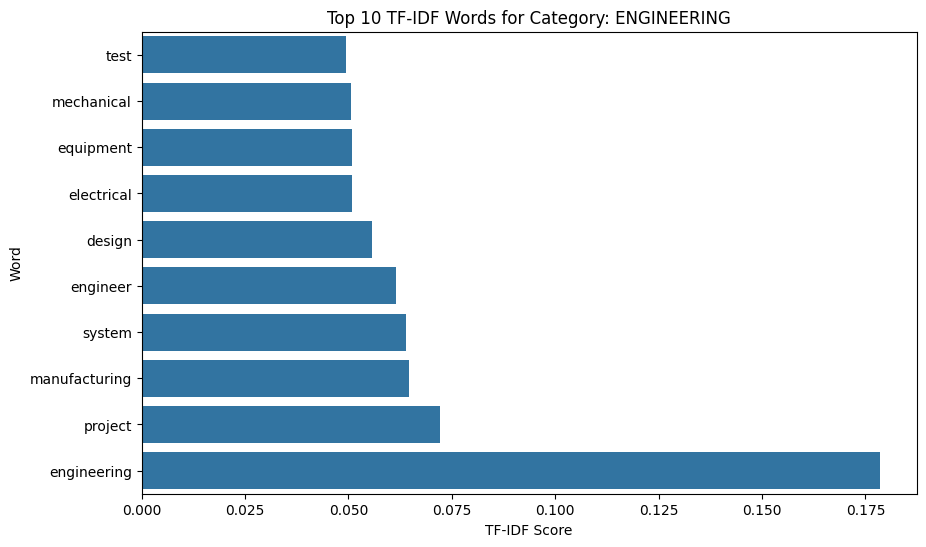

In [12]:
def plot_top_tfidf_words(category, top_n=10):
    """
    Plot top TF-IDF words for a given category.
    """
    category_indices = df[df['Category'] == category].index
    category_tfidf = X[category_indices].toarray()
    mean_tfidf = np.mean(category_tfidf, axis=0)
    top_n_indices = np.argsort(mean_tfidf)[-top_n:]
    
    top_words = [vectorizer.get_feature_names_out()[i] for i in top_n_indices]
    top_scores = [mean_tfidf[i] for i in top_n_indices]
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x=top_scores, y=top_words)
    plt.title(f'Top {top_n} TF-IDF Words for Category: {category}')
    plt.xlabel('TF-IDF Score')
    plt.ylabel('Word')
    plt.show()

# Example: Plot top TF-IDF words for the 'ENGINEERING' category
plot_top_tfidf_words('ENGINEERING')


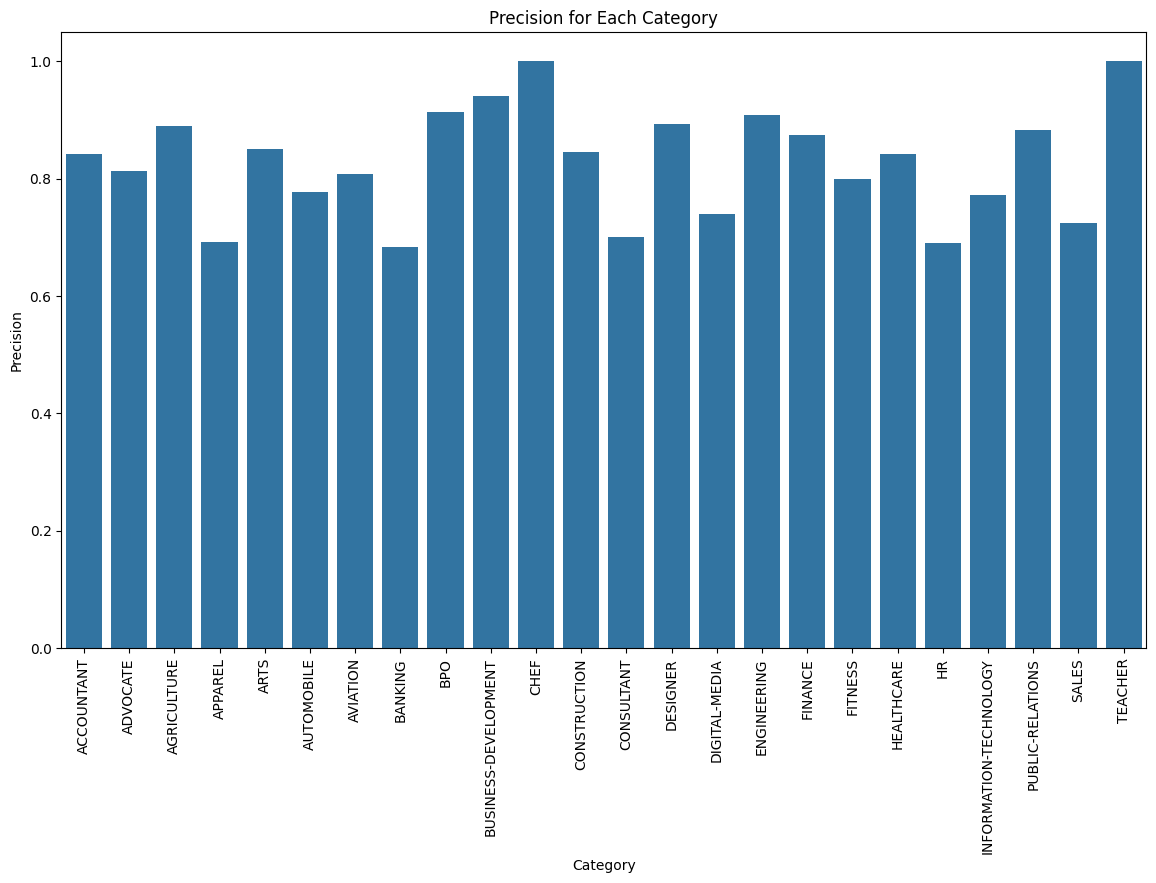

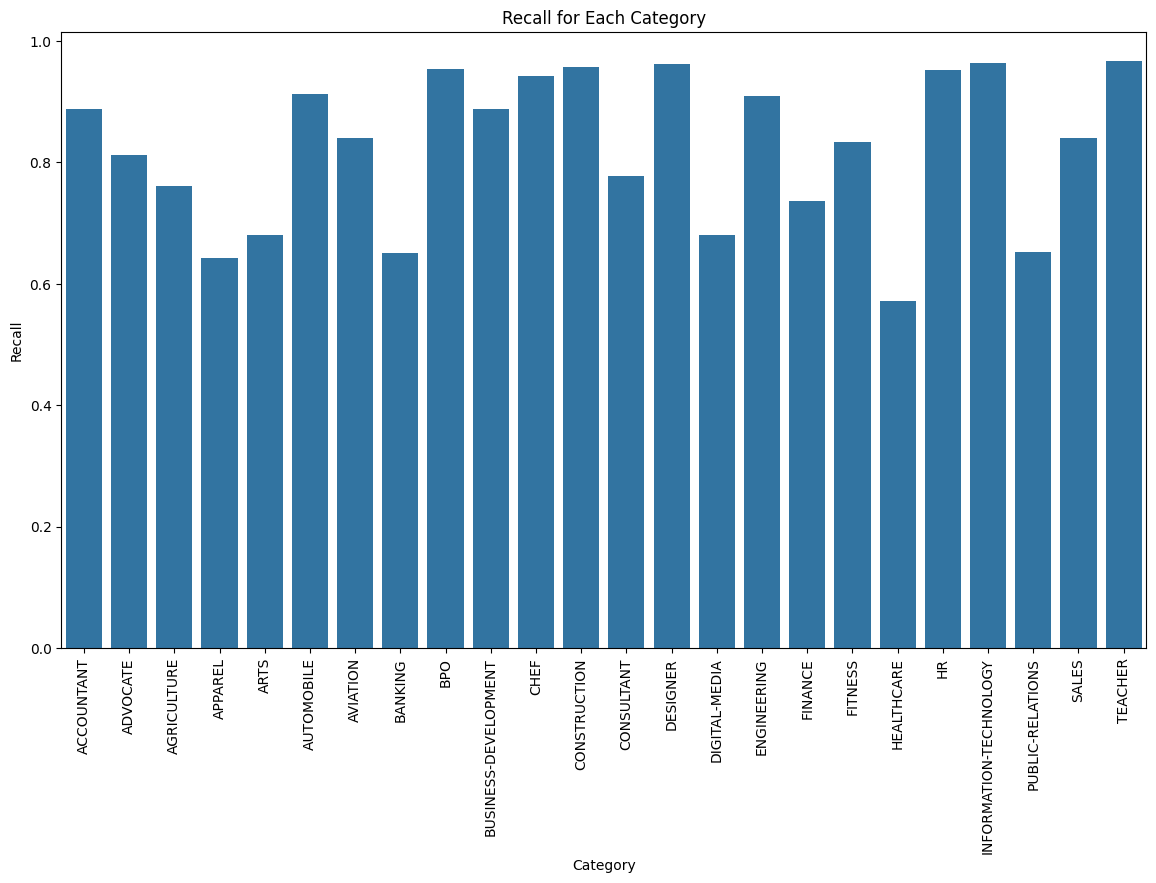

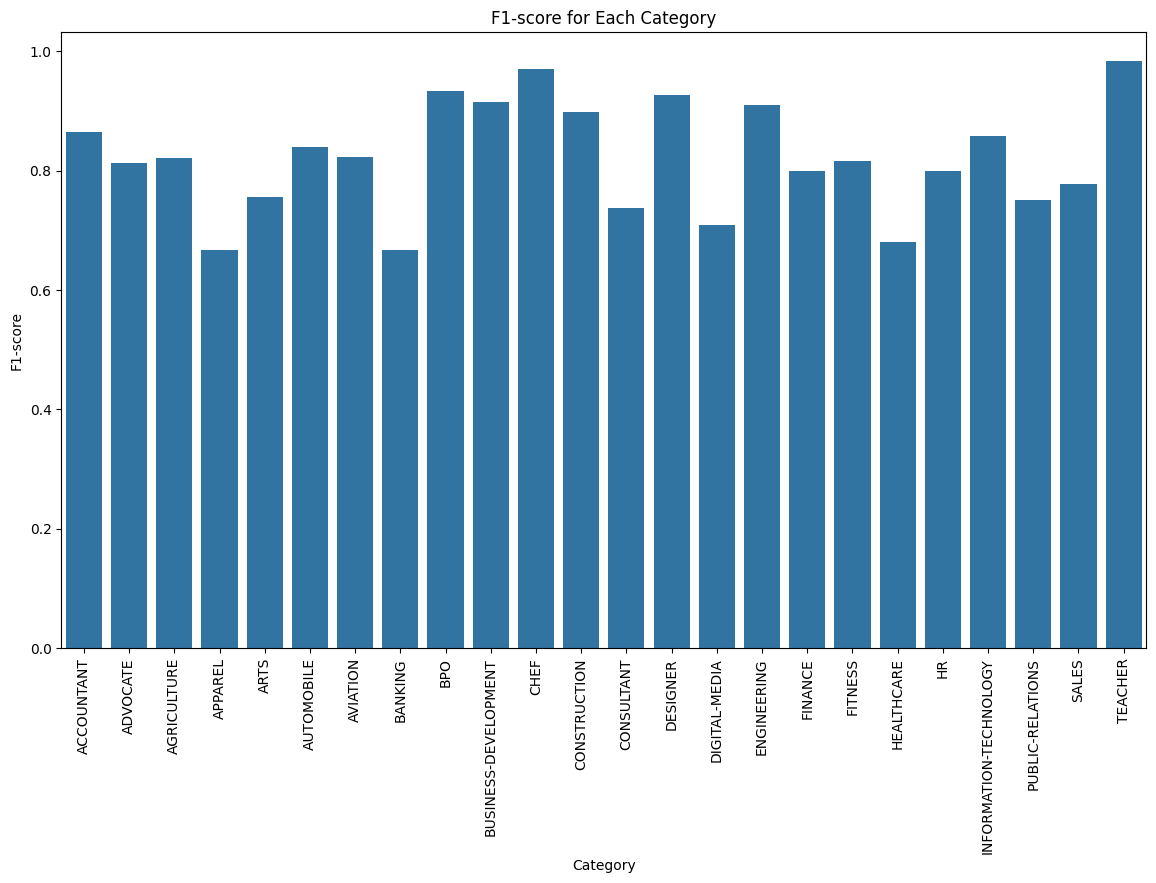

In [13]:
def plot_classification_report(report, metric='f1-score'):
    """
    Plot precision, recall, and F1-score for each category.
    """
    metrics_df = pd.DataFrame(report).transpose().iloc[:-3, :3]
    
    plt.figure(figsize=(14, 8))
    sns.barplot(x=metrics_df.index, y=metrics_df[metric])
    plt.title(f'{metric.capitalize()} for Each Category')
    plt.xlabel('Category')
    plt.ylabel(metric.capitalize())
    plt.xticks(rotation=90)
    plt.show()

# Generate classification report as a dictionary
report = classification_report(y_test, y_pred, target_names=label_encoder.classes_, output_dict=True)

# Plot precision, recall, and F1-score
plot_classification_report(report, metric='precision')
plot_classification_report(report, metric='recall')
plot_classification_report(report, metric='f1-score')


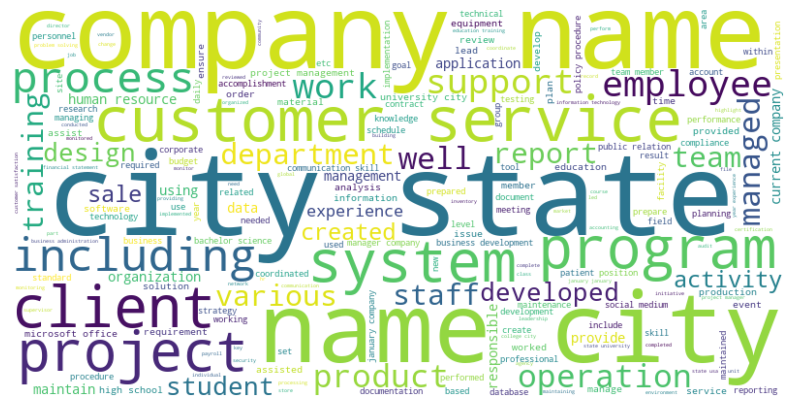

In [17]:
from wordcloud import WordCloud

def plot_word_cloud(text):
    """
    Plot word cloud for given text.
    """
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

# Combine all processed resumes into a single string
all_text = ' '.join(df['resume_processed'])

# Plot word cloud
plot_word_cloud(all_text)


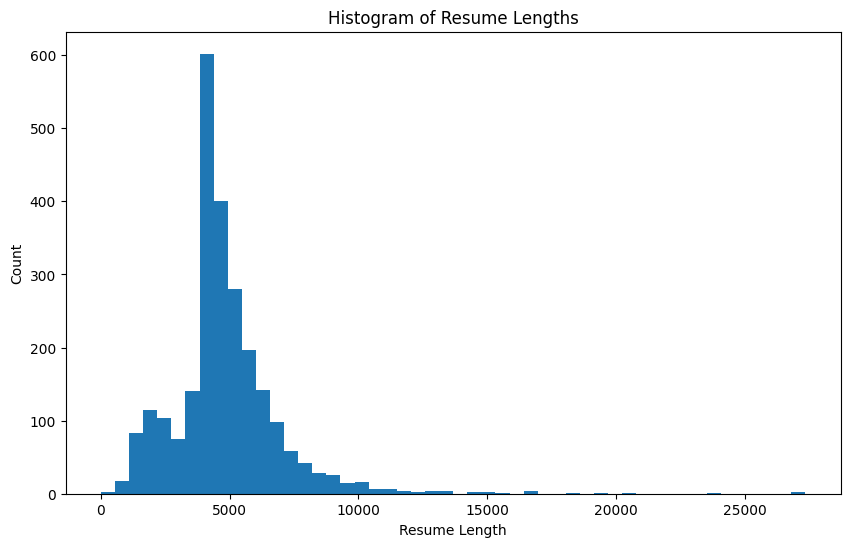

In [18]:
#Histogram of Resume Lengths:
plt.figure(figsize=(10, 6)) 
plt.hist(df['resume_processed'].apply(lambda x: len(x)), bins=50)
plt.title('Histogram of Resume Lengths')
plt.xlabel('Resume Length')
plt.ylabel('Count')
plt.show()

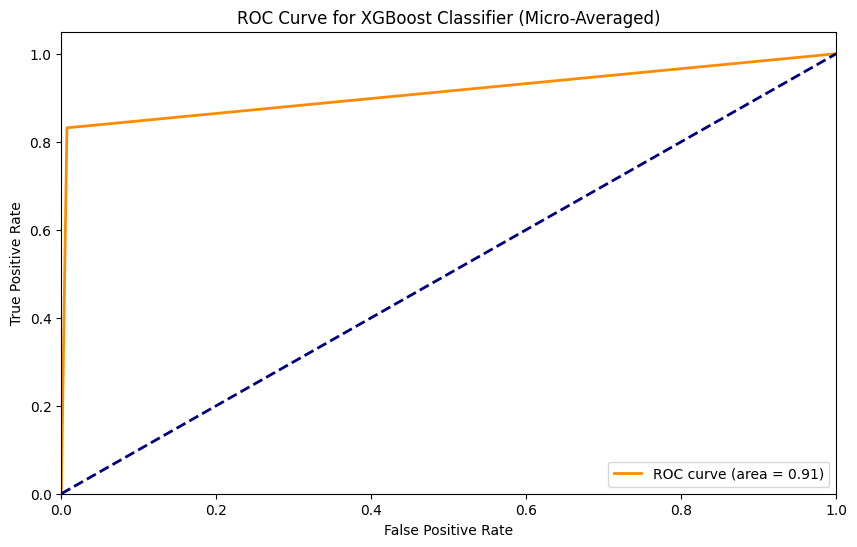

In [20]:
# One-vs-Rest (OvR) Approach:
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

# Convert y_test and y_pred to one-hot encoded format
from sklearn.preprocessing import label_binarize
y_test_bin = label_binarize(y_test, classes=range(len(label_encoder.classes_)))
y_pred_bin = label_binarize(y_pred, classes=range(len(label_encoder.classes_)))

n_classes = len(label_encoder.classes_)

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_bin.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curve
plt.figure(figsize=(10, 6))
lw = 2
plt.plot(fpr["micro"], tpr["micro"], color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc["micro"])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for XGBoost Classifier (Micro-Averaged)')
plt.legend(loc="lower right")
plt.show()


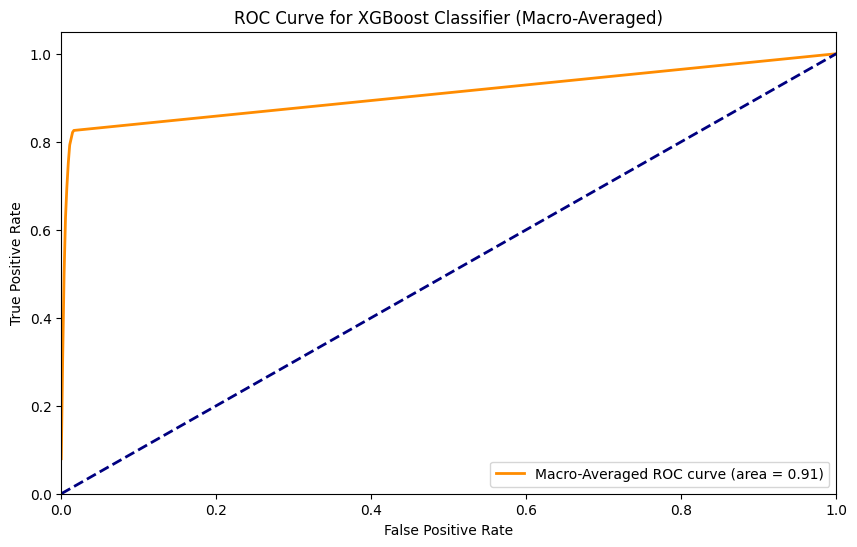

In [22]:
# Compute ROC curve and ROC area for each class
#2. Macro-Averaging Approach:
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute macro-average ROC curve and ROC area
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot ROC curve
plt.figure(figsize=(10, 6))
lw = 2
plt.plot(fpr["macro"], tpr["macro"], color='darkorange', lw=lw, label='Macro-Averaged ROC curve (area = %0.2f)' % roc_auc["macro"])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for XGBoost Classifier (Macro-Averaged)')
plt.legend(loc="lower right")
plt.show()


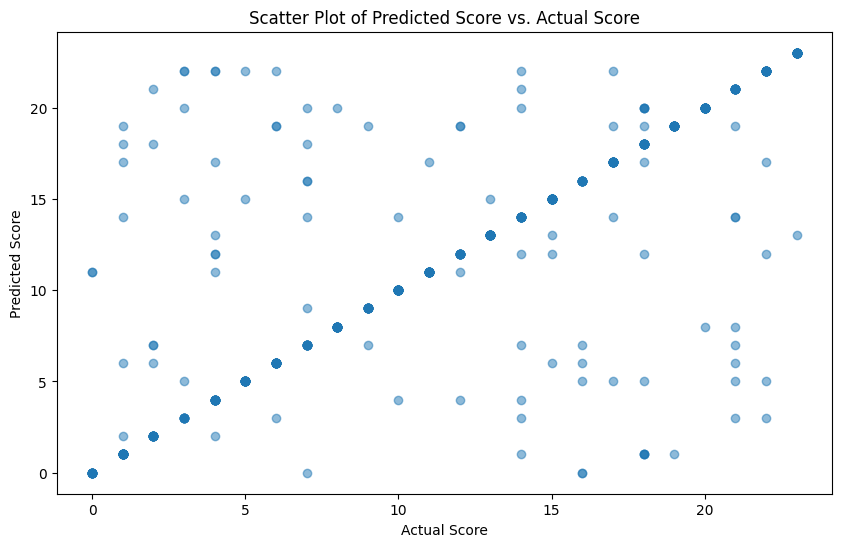

In [23]:
#Scatter Plot of Predicted Score vs. Actual Score:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('Actual Score')
plt.ylabel('Predicted Score')
plt.title('Scatter Plot of Predicted Score vs. Actual Score')
plt.show()


c:\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
1 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Python312\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Python312\Lib\site-packages\xgboost\sklearn.py", line 1491, in fit
    raise ValueError(
ValueError: Invalid classes inferred from unique values of `y`.  Expected: [ 0  1  2  3  4  5  6  7  8  9 

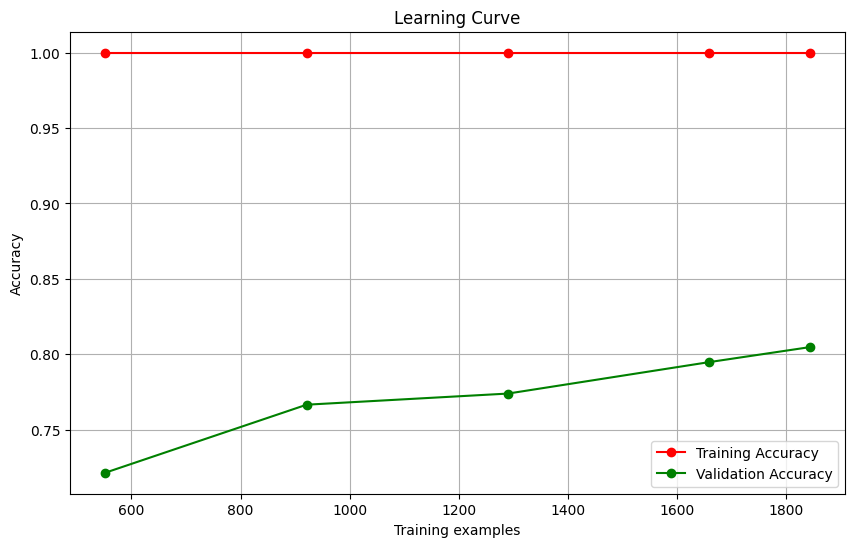

In [25]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import learning_curve

# Assuming you have defined and trained your XGBoost model 'xgb'
# and you have training data 'X_train', 'y_train'
train_sizes, train_scores, valid_scores = learning_curve(xgb, X_train, y_train, train_sizes=[0.1, 0.3, 0.5, 0.7, 0.9, 1.0], cv=5)

train_scores_mean = np.mean(train_scores, axis=1)
valid_scores_mean = np.mean(valid_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training Accuracy")
plt.plot(train_sizes, valid_scores_mean, 'o-', color="g", label="Validation Accuracy")
plt.xlabel("Training examples")
plt.ylabel("Accuracy")
plt.title("Learning Curve")
plt.legend(loc="best")
plt.grid()
plt.show()
